On rajoute les données meteo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.ensemble import RandomForestRegressor

In [4]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations_debit = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [5]:
stations_meteo = pd.read_csv("../Data/Base/Stations_Meteo.csv")
liste_stations_meteo = list(stations_meteo["ID"].apply(lambda x: str(x).rjust(5, "0")))
colonnes_meteo = ["Pression", "Vent_Nord", "Vent_Est", "Vitesse_vent", "Temperature", "Humidite", "Precipitations"]
tempo = []
for code in liste_stations_meteo:
    tempo += [tp + "_" + code for tp in colonnes_meteo]
colonnes_meteo_stations = tempo

In [6]:
%run Eval_fcts.py
%run Standardize_fcts.py

In [7]:
%run Regression_GAM_Gamma.py

# Val croisée

In [10]:
depth = 3
feature_grid = ["auto"]
sample_grid = [2, 4, 6, 8, 10]
n_knots = 10

sample_grid = [10]
min_lag = 0
max_lag = 7

In [7]:
for curr_feature in feature_grid:
    for curr_sample in sample_grid:
        for curr_lag in tqdm(range(min_lag, max_lag+1)):
        
            cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations_debit})
            cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations_debit})
            cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations_debit})

            cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations_debit})
            cv_scores_MAE = pd.DataFrame({"Code station": liste_stations_debit})
            cv_scores_R2 = pd.DataFrame({"Code station": liste_stations_debit})
    
            for curr_split in range(9):
        
            # Entraintement
                curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
                curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
                curr_train_X_mean = curr_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
                for code in liste_stations_debit:
                    curr_train_X_mean[code] = 0
                curr_train_X_std = curr_train_X[liste_stations_debit + colonnes_meteo_stations].std()
                curr_train_X_standard = fct_Standardize(curr_train_X, curr_train_X_mean,
                                                    curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
                curr_train_X_standard["Date"] = curr_train_X["Date"]
                    #GAM
                spline_fit = fct_Regression_SplineGamma_fit(curr_train_X_standard, liste_stations_debit, n_knots)
                curr_train_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, 
                                                                                   curr_train_X_standard, 
                                                                                   liste_stations_debit)
                curr_train_X_standard_residus = pd.concat([curr_train_X_standard_residus, 
                                                          curr_train_X_standard[colonnes_meteo_stations]],
                                                         axis = 1)
                    # Ajout AR
                colonnes_reg = colonnes_meteo_stations
                for i in range(curr_lag+1):
                    variable = curr_train_X_standard_residus[liste_stations_debit].shift(i+7)
                    variable.columns = [code+"_"+str(i) for code in liste_stations_debit]
                    curr_train_X_standard_residus = pd.concat([curr_train_X_standard_residus, variable], axis = 1)
                    colonnes_reg = colonnes_reg + [code+"_"+str(i) for code in liste_stations_debit]
                curr_train_X_standard_residus = curr_train_X_standard_residus[(7+curr_lag):]
                
                    # RF
                model_RF = RandomForestRegressor(max_features=curr_feature,
                                                max_samples=curr_sample/10)
                model_RF.fit(X = curr_train_X_standard_residus[colonnes_reg],
                             y = curr_train_X_standard_residus[liste_stations_debit])
        
                # Predictions Standard
                curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
                curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
                liste_dates = curr_test_Y["Date"]
                curr_test_X_standard =fct_Standardize(curr_test_X, curr_train_X_mean,
                                                  curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
                curr_test_X_standard["Date"] = curr_test_X["Date"].values
                curr_test_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit,
                                                                              curr_test_X_standard, 
                                                                              liste_stations_debit)
                curr_test_X_standard_residus = pd.concat([curr_test_X_standard_residus, 
                                                          curr_test_X_standard[colonnes_meteo_stations]],
                                                         axis = 1)
                    # Ajout variables AR
                for i in range(curr_lag+1):
                    variable = curr_test_X_standard_residus[liste_stations_debit].shift(i+7)
                    variable.columns = [code+"_"+str(i) for code in liste_stations_debit]
                    curr_test_X_standard_residus = pd.concat([curr_test_X_standard_residus, variable], axis = 1)
                curr_test_X_standard_residus = curr_test_X_standard_residus[(7+curr_lag):]
                    # RF
                predictions_test_Y_standard_residus = model_RF.predict(curr_test_X_standard_residus[colonnes_reg])
                predictions_test_Y_standard_residus = pd.DataFrame(predictions_test_Y_standard_residus, columns=liste_stations_debit)
                predictions_test_Y_standard_residus["Date"] = curr_test_X_standard_residus["Date"].values
                # Filtre sur les dates
                resultat = pd.DataFrame()
                for curr_date in liste_dates:
                    resultat = pd.concat([resultat, predictions_test_Y_standard_residus[predictions_test_Y_standard_residus["Date"] == curr_date]])
                resultat = resultat.sort_values(by = "Date")
                predictions_test_Y_standard_residus = resultat.copy()
                # On rajoute la compo saisonnalité
                predictions_test_Y_standard_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations_debit)
                predictions_test_Y_standard = predictions_test_Y_standard_residus[["Date"]].copy()
                for code in liste_stations_debit:
                    predictions_test_Y_standard[code] = predictions_test_Y_standard_residus[code].values + predictions_test_Y_standard_saisonnalite[code].values

        
                # Score standard
                curr_test_Y_standard = fct_Standardize(curr_test_Y, 
                                                       curr_train_X_mean, curr_train_X_std, 
                                                       liste_stations_debit)
                curr_test_Y_standard["Date"] = curr_test_Y["Date"]
                curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
                cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
                curr_MAE = fct_MAE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
                cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
                curr_R2 = fct_R2(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
                cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]
                # Score
                predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, 
                                                       curr_train_X_mean, curr_train_X_std, 
                                                       liste_stations_debit)
                predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values
                curr_RMSE = fct_RMSE(curr_test_Y, predictions_test_Y, liste_stations_debit)
                cv_scores_RMSE["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
                curr_MAE = fct_MAE(curr_test_Y, predictions_test_Y, liste_stations_debit)
                cv_scores_MAE["Split_" + str(curr_split)] = curr_MAE["MAE"]
                curr_R2 = fct_R2(curr_test_Y, predictions_test_Y, liste_stations_debit)
                cv_scores_R2["Split_" + str(curr_split)] = curr_R2["R2"]
    
            cv_moyen_RMSE_standard = []
            cv_moyen_MAE_standard = []
            cv_moyen_R2_standard = []

            cv_moyen_RMSE = []
            cv_moyen_MAE = []
            cv_moyen_R2 = []

            for code in liste_stations_debit:
                score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
                cv_moyen_RMSE_standard.append(score_RMSE)
                score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
                cv_moyen_MAE_standard.append(score_MAE)
                score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
                cv_moyen_R2_standard.append(score_R2)
                score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
                cv_moyen_RMSE.append(score_RMSE)
                score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
                cv_moyen_MAE.append(score_MAE)
                score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
                cv_moyen_R2.append(score_R2)

            cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
            cv_scores_RMSE_standard.to_csv("../Data/GAMRandomForestAR/CV_RMSE_standard_" + str(curr_feature) + "_" + str(curr_sample) + "_" + str(curr_lag) + ".csv",
                                  index=False)
            cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
            cv_scores_MAE_standard.to_csv("../Data/GAMRandomForestAR/CV_MAE_standard_" + str(curr_feature) + "_" + str(curr_sample) + "_" + str(curr_lag) + ".csv",
                                  index=False)
            cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
            cv_scores_R2_standard.to_csv("../Data/GAMRandomForestAR/CV_R2_standard_" + str(curr_feature) + "_" + str(curr_sample) + "_" + str(curr_lag) + ".csv",
                                  index=False)
            cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
            cv_scores_RMSE.to_csv("../Data/GAMRandomForestAR/CV_RMSE_" + str(curr_feature) + "_" + str(curr_sample) + "_" + str(curr_lag) + ".csv",
                                  index=False)
            cv_scores_MAE["Moyenne"] = cv_moyen_MAE
            cv_scores_MAE.to_csv("../Data/GAMRandomForestAR/CV_MAE_" + str(curr_feature) + "_" + str(curr_sample) + "_" + str(curr_lag) + ".csv",
                                  index=False)
            cv_scores_R2["Moyenne"] = cv_moyen_R2
            cv_scores_R2.to_csv("../Data/GAMRandomForestAR/CV_R2_" + str(curr_feature) + "_" + str(curr_sample) + "_" + str(curr_lag) + ".csv",
                                  index=False)
print("OK")

100%|██████████████████████████████████████████| 8/8 [1:36:07<00:00, 720.99s/it]

OK


## Selection

In [11]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

,Cours eau,Index,Couleur
0,Garonne,0,red
1,Loire,1,green
2,Seine,2,blue


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 89.09it/s]


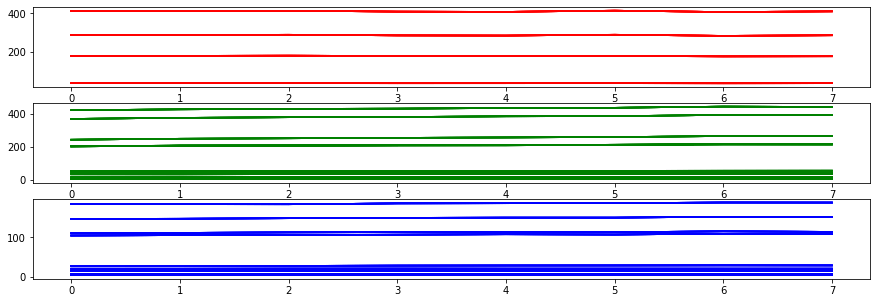

In [44]:
cv_moyen = pd.DataFrame()
curr_feature="auto"
for curr_lag in tqdm(range(min_lag, max_lag+1)):
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMRandomForestAR/CV_RMSE_" + str(curr_feature) + "_" + str(curr_sample) +"_"+ str(curr_lag)+ ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["lags"]=curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, len(feature_grid), figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        for j in range(min_lag, max_lag+1):
            axs[i].plot(cv_moyen["lags"], 
                          cv_moyen[code],
                          color = cours_eau_cmap(i))
plt.show()

In [41]:
cv_moyen[cv_moyen["lags"] == 10][code]

Series([], Name: O0200020, dtype: float64)

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 87.87it/s]


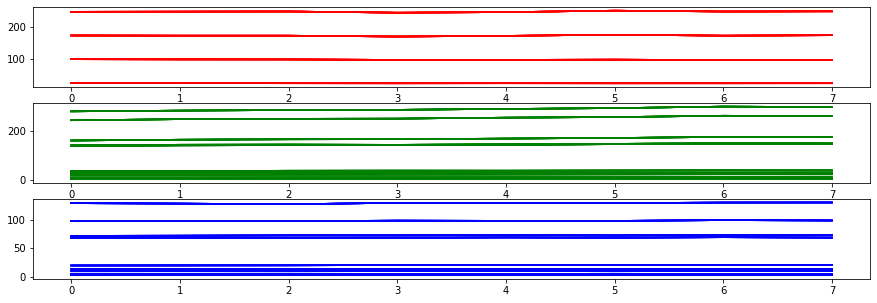

In [45]:
cv_moyen = pd.DataFrame()
curr_feature="auto"
for curr_lag in tqdm(range(min_lag, max_lag+1)):
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMRandomForestAR/CV_MAE_" + str(curr_feature) + "_" + str(curr_sample) +"_"+ str(curr_lag)+ ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["lags"]=curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, len(feature_grid), figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        for j in range(min_lag, max_lag+1):
            axs[i].plot(cv_moyen["lags"], 
                          cv_moyen[code],
                          color = cours_eau_cmap(i))
plt.show()

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 78.91it/s]


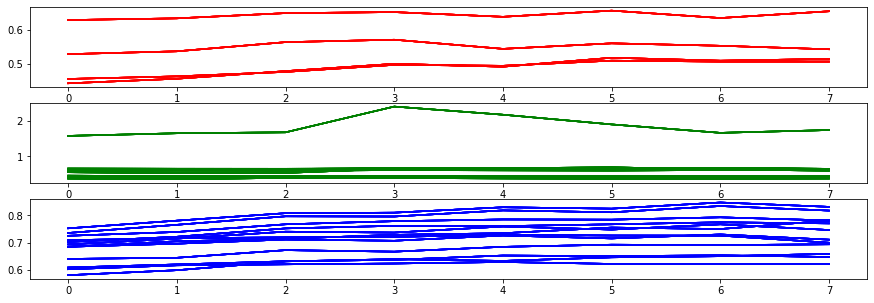

In [46]:
cv_moyen = pd.DataFrame()
curr_feature="auto"
for curr_lag in tqdm(range(min_lag, max_lag+1)):
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMRandomForestAR/CV_R2_" + str(curr_feature) + "_" + str(curr_sample) +"_"+ str(curr_lag)+ ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["lags"]=curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, len(feature_grid), figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        for j in range(min_lag, max_lag+1):
            axs[i].plot(cv_moyen["lags"], 
                          cv_moyen[code],
                          color = cours_eau_cmap(i))
plt.show()

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 77.08it/s]


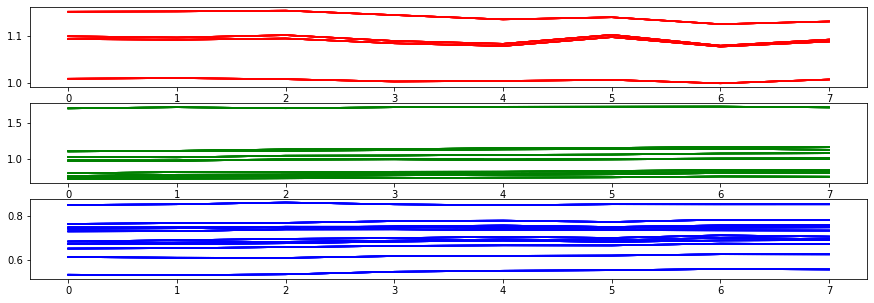

In [48]:
cv_moyen = pd.DataFrame()
curr_feature="auto"
for curr_lag in tqdm(range(min_lag, max_lag+1)):
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMRandomForestAR/CV_RMSE_standard_" + str(curr_feature) + "_" + str(curr_sample) +"_"+ str(curr_lag)+ ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["lags"]=curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, len(feature_grid), figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        for j in range(min_lag, max_lag+1):
            axs[i].plot(cv_moyen["lags"], 
                          cv_moyen[code],
                          color = cours_eau_cmap(i))
plt.show()

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 77.36it/s]


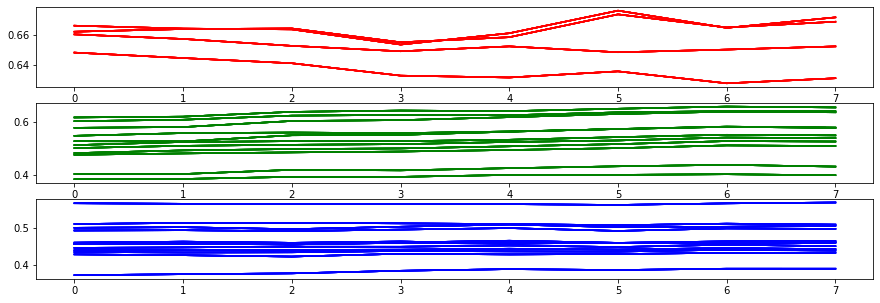

In [49]:
cv_moyen = pd.DataFrame()
curr_feature="auto"
for curr_lag in tqdm(range(min_lag, max_lag+1)):
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMRandomForestAR/CV_MAE_standard_" + str(curr_feature) + "_" + str(curr_sample) +"_"+ str(curr_lag)+ ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["lags"]=curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, len(feature_grid), figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        for j in range(min_lag, max_lag+1):
            axs[i].plot(cv_moyen["lags"], 
                          cv_moyen[code],
                          color = cours_eau_cmap(i))
plt.show()

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 80.68it/s]


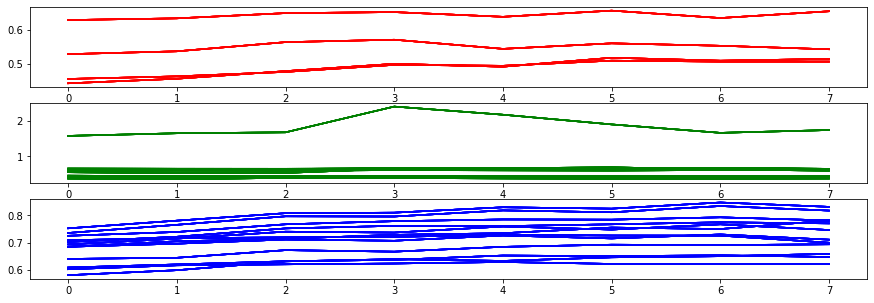

In [50]:
cv_moyen = pd.DataFrame()
curr_feature="auto"
for curr_lag in tqdm(range(min_lag, max_lag+1)):
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMRandomForestAR/CV_R2_standard_" + str(curr_feature) + "_" + str(curr_sample) +"_"+ str(curr_lag)+ ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["lags"]=curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, len(feature_grid), figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        for j in range(min_lag, max_lag+1):
            axs[i].plot(cv_moyen["lags"], 
                          cv_moyen[code],
                          color = cours_eau_cmap(i))
plt.show()

## Moyen

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 85.07it/s]


TypeError: 'AxesSubplot' object is not subscriptable

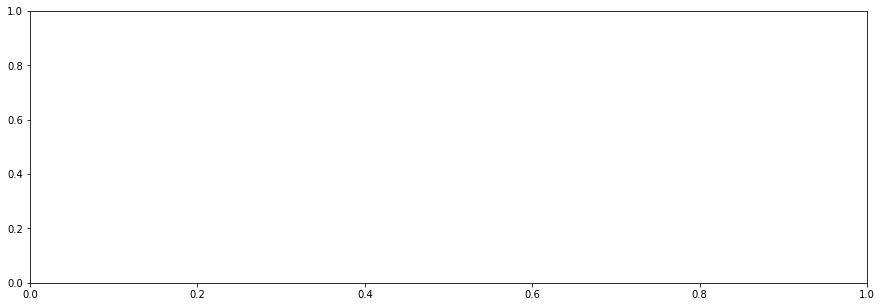

In [55]:
cv_moyen = pd.DataFrame()

for curr_lag in tqdm(range(min_lag, max_lag+1)):
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMRandomForestAR/CV_RMSE_standard_" + str(curr_feature) + "_" + str(curr_sample) +"_"+ str(curr_lag)+ ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["lags"]=curr_lag
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(1, len(feature_grid), figsize = (15,5), sharey=True)
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["lags"], 
                      cv_moyen[code],
                      color = cours_eau_cmap(i))
plt.show()

In [54]:
cv_moyen[code]

0    1.008618
0    1.010020
0    1.007607
0    1.002602
0    1.003855
0    1.006107
0    0.998746
0    1.006999
Name: O0200020, dtype: float64

In [ ]:
cv_moyen = pd.DataFrame()

for curr_feature in feature_grid:
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMRandomForestAR/CV_MAE_standard_" + str(curr_feature) + "_" + str(curr_sample) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Max_features"] = curr_feature
        curr_moyen["Max_samples"] = curr_sample
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(1, len(feature_grid), figsize = (15,5), sharey=True)
for j in range(len(feature_grid)):
    axs[j].plot(cv_moyen[cv_moyen["Max_features"] == feature_grid[i]]["Max_samples"], 
                  cv_moyen[cv_moyen["Max_features"] == feature_grid[i]][liste_stations_debit].mean(axis = 1).values,)
    axs[j].set_title(feature_grid[j])
plt.show()

In [ ]:
cv_moyen = pd.DataFrame()

for curr_feature in feature_grid:
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/GAMRandomForestAR/CV_R2_standard_" + str(curr_feature) + "_" + str(curr_sample) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Max_features"] = curr_feature
        curr_moyen["Max_samples"] = curr_sample
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(1, len(feature_grid), figsize = (15,5), sharey=True)
for j in range(len(feature_grid)):
    axs[j].plot(cv_moyen[cv_moyen["Max_features"] == feature_grid[i]]["Max_samples"], 
                  cv_moyen[cv_moyen["Max_features"] == feature_grid[i]][liste_stations_debit].mean(axis = 1).values,)
    axs[j].set_title(feature_grid[j])
plt.show()

# Test

In [25]:
sample = 0.8

In [26]:
# Donnees
mesures_train_X_mean = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
mesures_train_X_std = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].std()
mesures_train_X_standard = fct_Standardize(mesures_train_X, 
                                           mesures_train_X_mean, mesures_train_X_std, 
                                           liste_stations_debit + colonnes_meteo_stations)
mesures_train_X_standard["Date"] = mesures_train_X["Date"]

mesures_test_X_standard =fct_Standardize(mesures_test_X, mesures_train_X_mean, mesures_train_X_std, 
                                         liste_stations_debit + colonnes_meteo_stations)
mesures_test_X_standard["Date"] = mesures_test_X["Date"].values
mesures_test_Y_standard = fct_Standardize(mesures_test_Y, mesures_train_X_mean, mesures_train_X_std, 
                                          liste_stations_debit)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]
liste_dates = mesures_test_Y["Date"]

In [27]:
# Entrainement
model_RF = RandomForestRegressor(max_features=curr_feature,
                                max_samples=sample)
model_RF.fit(X = mesures_train_X_standard[colonnes_meteo_stations],
      y = mesures_train_X_standard[liste_stations_debit])

RandomForestRegressor(max_samples=0.8)

In [28]:
# Predictions
predictions_test_Y_standard = model_RF.predict(mesures_test_X_standard[colonnes_meteo_stations])
predictions_test_Y_standard = pd.DataFrame(predictions_test_Y_standard, columns=liste_stations_debit)
predictions_test_Y_standard["Date"] = mesures_test_X_standard["Date"].values
    # Filtre sur les dates
resultat = pd.DataFrame()
for curr_date in liste_dates:
    resultat = pd.concat([resultat, predictions_test_Y_standard[predictions_test_Y_standard["Date"] == curr_date]])
resultat = resultat.sort_values(by = "Date")
predictions_test_Y_standard = resultat.copy()

In [29]:
predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, mesures_train_X_mean,
                                              mesures_train_X_std, liste_stations_debit)
predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values

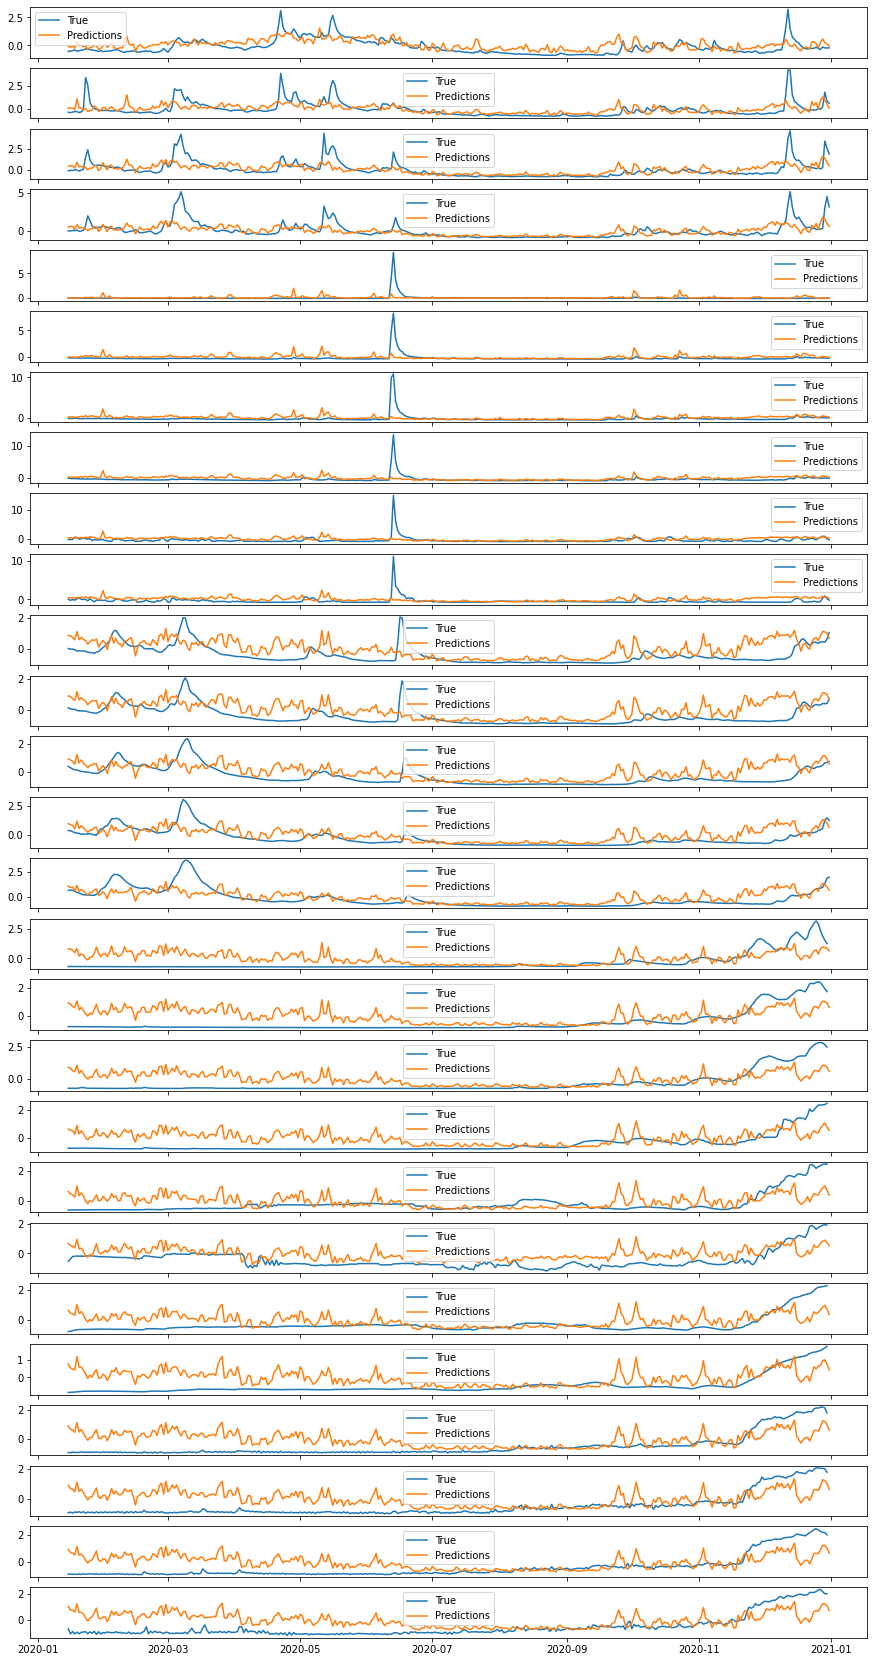

In [30]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y_standard["Date"], mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard["Date"], predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()

In [31]:
scores_rmse_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_mae_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_r2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)

test_scores_standard = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse_standard["RMSE"],
                            "MAE": scores_mae_standard["MAE"],
                            "R2": scores_r2_standard["R2"]})
test_scores_standard.to_csv("../Data/GAMRandomForestAR/Test_scores_standard.csv",
                   index = False)
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.554945,0.432579,0.394756
1,O2620010,0.689443,0.451568,0.273877
2,O6140010,0.778479,0.508841,0.317312
3,O9000010,0.842337,0.519404,0.299611
4,K0030020,0.636758,0.201604,0.160024
5,K0100020,0.688098,0.357539,0.262806
6,K0260020,0.980093,0.472484,0.207894
7,K0550010,1.070806,0.592127,0.251788
8,K0690010,1.145513,0.651731,0.223712
9,K0910050,1.002054,0.645143,0.285872


In [32]:
test_scores_standard[["RMSE", "MAE", "R2"]].mean()

RMSE    0.796104
MAE     0.498862
R2      0.370686
dtype: float64

In [33]:
scores_rmse = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_mae = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_r2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations_debit)

test_scores = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse["RMSE"],
                            "MAE": scores_mae["MAE"],
                            "R2": scores_r2["R2"]})
test_scores.to_csv("../Data/GAMRandomForestAR/Test_scores.csv",
                   index = False)
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,25.761470,20.081014,0.394756
1,O2620010,136.657386,89.507141,0.273877
2,O6140010,256.151456,167.429564,0.317312
3,O9000010,409.556786,252.542127,0.299611
4,K0030020,3.904964,1.236355,0.160024
5,K0100020,6.479013,3.366527,0.262806
6,K0260020,18.155725,8.752524,0.207894
7,K0550010,39.012076,21.572645,0.251788
8,K0690010,51.246350,29.156230,0.223712
9,K0910050,57.861079,37.252199,0.285872
